In [ ]:
import os
import sys
from mxnet import gluon
from mxnet import image
from mxnet import nd
import mxnet as mx
from mxnet.gluon import nn
# %matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from mxnet import autograd
from mxnet.contrib.ndarray import MultiBoxTarget
from mxnet.contrib.ndarray import MultiBoxDetection
from mxnet.contrib.ndarray import MultiBoxPrior
from mxnet import init
from mxnet import metric
import time


def get_gpu(num_gpu):
    if num_gpu > 0:
        ctx = [mx.gpu(i) for i in range(num_gpu)]
    else:
        ctx = [mx.cpu()]
    return ctx


# 下载数据
def download_data(data_dir=None):
    root_url = ('https://apache-mxnet.s3-accelerate.amazonaws.com/gluon/dataset/pikachu/')
    if data_dir is not None:
        data_dir = 'data/pikachu/'
    dataset = {'train.rec': 'e6bcb6ffba1ac04ff8a9b1115e650af56ee969c8',
               'train.idx': 'dcf7318b2602c06428b9988470c731621716c393',
               'val.rec': 'd6c33f799b4d058e82f2cb5bd9a976f69d72d520'}

    for k, v in dataset.items():
        gluon.utils.download(root_url + k, data_dir + k, sha1_hash=v)


# 读取数据集
# 使用image.ImageDetIter来读取数据。这是针对物体检测的迭代器，(Det表示Detection)。
# 它跟image.ImageIter使用很类似。主要不同是它返回的标号不是单个图片标号，而是每个图片里所有物体的标号，以及其对用的边框。
def get_iterators(data_dir, data_shape, batch_size):
    class_names = ['pikachu']
    num_class = len(class_names)
    train_iter = image.ImageDetIter(batch_size=batch_size, data_shape=(3, data_shape, data_shape),
        path_imgrec=data_dir + 'train.rec', path_imgidx=data_dir + 'train.idx',
        shuffle=True, mean=True, rand_crop=1, min_object_covered=0.95, max_attempts=200)

    val_iter = image.ImageDetIter(batch_size=batch_size, data_shape=(3, data_shape, data_shape),
        path_imgrec=data_dir + 'val.rec', shuffle=False, mean=True)
    return train_iter, val_iter, class_names, num_class


def box_to_rect(box, color, linewidth=3):
    """convert an anchor box to a matplotlib rectangle"""
    box = box.asnumpy()
    return plt.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1], fill=False, edgecolor=color, linewidth=linewidth)


class FocalLoss(gluon.loss.Loss):
    def __init__(self, axis=-1, alpha=0.25, gamma=2, batch_axis=0, **kwargs):
        super(FocalLoss, self).__init__(None, batch_axis, **kwargs)
        self._axis = axis
        self._alpha = alpha
        self._gamma = gamma

    def hybrid_forward(self, F, output, label):
        output = F.softmax(output)
        pj = output.pick(label, axis=self._axis, keepdims=True)
        loss = - self._alpha * ((1 - pj) ** self._gamma) * pj.log()
        return loss.mean(axis=self._batch_axis, exclude=True)


class SmoothL1Loss(gluon.loss.Loss):
    def __init__(self, batch_axis=0, **kwargs):
        super(SmoothL1Loss, self).__init__(None, batch_axis, **kwargs)

    def hybrid_forward(self, F, output, label, mask):
        loss = F.smooth_l1((output - label) * mask, scalar=1.0)
        return loss.mean(self._batch_axis, exclude=True)


class ToySSD(gluon.Block):
    def __init__(self, num_classes, verbose=False, **kwargs):
        super(ToySSD, self).__init__(**kwargs)
        # anchor box sizes and ratios for 5 feature scales
        self.sizes = [[.2,.272], [.37, .447], [.54, .619], [.71, .79], [.88, .961]]
        self.ratios = [[1, 2, .5]]*5
        self.num_classes = num_classes
        self.verbose = verbose
        self.num_anchors = len(self.sizes[0]) + len(self.ratios[0]) - 1
        # print('[num_anchors]', self.num_anchors)
        # use name_scope to guard the names
        with self.name_scope():
            self.model = self.toy_ssd_model(self.num_anchors, self.num_classes)

    # 合并来自不同层的预测输出
    # 前面我们提到过SSD的一个重要性质是它会在多个层同时做预测。每个层由于长宽和锚框选择不一样，导致输出的数据形状会不一样。
    # 这里我们用物体类别预测作为样例，边框预测是类似的。
    # 我们首先创建一个特定大小的输入，然后对它输出类别预测。然后对输入减半，再输出类别预测。
    def flatten_prediction(self, pred):
        return pred.transpose(axes=(0, 2, 3, 1)).flatten()  # 0123换成0231，(2, 8, 20, 20)变(2, 20, 20， 8)

    def concat_predictions(self, preds):
        return nd.concat(*preds, dim=1)

    # 预测物体类别：类别分类器函数
    # 对每一个锚框我们需要预测它是不是包含了我们感兴趣的物体，还是只是背景。这里我们使用一个3×3的卷积层来做预测，
    # 加上pad=1使用它的输出和输入一样。同时输出的通道数是num_anchors*(num_classes+1)，每个通道对应一个锚框对某个类的置信度。
    # 假设输出是Y，那么对应输入中第n个样本的第(i,j)像素的置信值是在Y[n,:,i,j]里。具体来说，对于以(i,j)为中心的第a个锚框，
    # 通道 a*(num_class+1) 是其只包含背景的分数
    # 通道 a*(num_class+1)+1+b 是其包含第b个物体的分数
    def class_predictor(self, num_anchors, num_classes):
        """return a layer to predict classes"""
        return nn.Conv2D(channels=num_anchors * (num_classes + 1), kernel_size=3, padding=1)

    # 预测边界框
    # 因为真实的边界框可以是任意形状，我们需要预测如何从一个锚框变换成真正的边界框。这个变换可以由一个长为4的向量来描述。同上一样，
    # 我们用一个有num_anchors 4通道的卷积。假设输出是Y，那么对应输入中第 n 个样本的第 (i,j) 像素为中心的锚框的转换在Y[n,:,i,j]里。
    # 具体来说，对于第a个锚框，它的变换在a4到a*4+3通道里。
    def box_predictor(self, num_anchors):
        """return a layer to predict delta locations"""
        return nn.Conv2D(num_anchors * 4, 3, padding=1)

    # 减半模块
    def down_sample(self, num_filters):
        """stack two Conv-BatchNorm-Relu blocks and then a pooling layer
        to halve the feature size"""
        out = nn.HybridSequential()
        for _ in range(2):
            out.add(nn.Conv2D(num_filters, 3, strides=1, padding=1))    # 卷积层
            out.add(nn.BatchNorm(in_channels=num_filters))              # BN层，批量规范化
            out.add(nn.Activation('relu'))                              # 激活层

        out.add(nn.MaxPool2D(2))
        return out

    # 主体网络
    # 主体网络用来从原始像素抽取特征。通常前面介绍的用来图片分类的卷积神经网络，例如ResNet，都可以用来作为主体网络。
    def body(self):
        out = nn.HybridSequential()
        for nfilters in [16, 32, 64]:
            out.add(self.down_sample(nfilters))
        return out

    # 创建一个玩具SSD模型
    # 这个网络包含四块。主体网络，三个减半模块，以及五个物体类别和边框预测模块。其中预测分别应用在在主体网络输出，减半模块输出，和最后的全局池化层上。
    def toy_ssd_model(self, num_anchors, num_classes):
        downsamplers = nn.Sequential()
        for _ in range(3):
            downsamplers.add(self.down_sample(128))                                 # 减半模块

        class_predictors = nn.Sequential()
        box_predictors = nn.Sequential()
        for i in range(5):
            class_predictors.add(self.class_predictor(num_anchors, num_classes))    # 物体类别预测模块
            box_predictors.add(self.box_predictor(num_anchors))                     # 边框预测模块

        model = nn.Sequential()
        model.add(self.body(), downsamplers, class_predictors, box_predictors)      # 把几个模块加起来
        return model

    def toy_ssd_forward(self, x, model, sizes, ratios, verbose=False):
        body, downsamplers, class_predictors, box_predictors = model
        anchors, class_preds, box_preds = [], [], []
        # feature extraction
        x = body(x)
        for i in range(5):
            # predict
            # MultiBoxPrior来采样锚框。这里锚框通过左下角和右上角两个点来确定，而且被标准化成了区间[0,1]的实数。
            anchors.append(MultiBoxPrior(x, sizes=sizes[i], ratios=ratios[i]))
            class_preds.append(self.flatten_prediction(class_predictors[i](x)))  # 变换通道：0123换成0231，(2, 8, 20, 20)变(2, 20, 20， 8)
            box_preds.append(self.flatten_prediction(box_predictors[i](x)))      # 变换通道：0123换成0231，(2, 8, 20, 20)变(2, 20, 20， 8)
            if verbose:
                print('Predict scale', i, x.shape, 'with', anchors[-1].shape[1], 'anchors')
            # down sample
            if i < 3:
                x = downsamplers[i](x)
            elif i == 3:
                x = nd.Pooling(x, global_pool=True, pool_type='max', kernel=(x.shape[2], x.shape[3]))
        # concat data
        return (self.concat_predictions(anchors),       # 合并
                self.concat_predictions(class_preds),   # 合并
                self.concat_predictions(box_preds))     # 合并

    def forward(self, x):
        anchors, class_preds, box_preds = self.toy_ssd_forward(x, self.model, self.sizes, self.ratios, verbose=self.verbose)
        # it is better to have class predictions reshaped for softmax computation
        class_preds = class_preds.reshape(shape=(0, -1, self.num_classes+1))
        return anchors, class_preds, box_preds


# ======================================================================================================================
def training_targets(anchors, class_preds, labels):
    class_preds = class_preds.transpose(axes=(0, 2, 1))
    return MultiBoxTarget(anchors, labels, class_preds)


# 预测模型
def process_image(file_name, data_shape, rgb_mean):
    with open(file_name, 'rb') as f:
        im = image.imdecode(f.read())
    # resize to data_shape
    data = image.imresize(im, data_shape, data_shape)
    # minus rgb mean
    data = data.astype('float32') - rgb_mean
    # convert to batch x channel x height xwidth
    return data.transpose((2, 0, 1)).expand_dims(axis=0), im


def predict(x, net, ctx):
    anchors, cls_preds, box_preds = net(x.as_in_context(ctx))
    cls_probs = nd.SoftmaxActivation(cls_preds.transpose((0, 2, 1)), mode='channel')
    return MultiBoxDetection(cls_probs, box_preds, anchors, force_suppress=True, clip=False)


def start_test(file_name, data_shape, rgb_mean, num_class, save_model_name, load_flag=True):
    print('[start test] ...')
    ctx = get_gpu(1)
    print(ctx)

    net = ToySSD(num_class)
    # net.initialize(init.Xavier(magnitude=2), ctx=ctx[0])
    if load_flag is True:               # 加载模型
        net.load_params(filename=save_model_name, ctx=ctx[0])

    x, im = process_image(file_name, data_shape, rgb_mean)
    out = predict(x, net, ctx[0])
    # print('[predict]', out)
    # print('[out_shape]', out.shape)


def start_train(train_data, test_data, num_epochs, num_class, batch_size, save_csv_name, save_model_name,
                load_flag=False, save_flag=True):
    print('[start train] ...')
    ctx = get_gpu(1)
    print(ctx)
    # 初始化模型和训练器
    # the CUDA implementation requres each image has at least 3 lables.
    # Padd two -1 labels for each instance
    train_data.reshape(label_shape=(3, 5))
    train_data = test_data.sync_label_shape(train_data)

    net = ToySSD(num_class)
    if load_flag is False:
        net.initialize(init.Xavier(magnitude=2), ctx=ctx[0])
    else:
        net.load_params(filename=save_model_name, ctx=ctx[0])
        
    trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.1, 'wd': 5e-4})

    cls_loss = FocalLoss()
    cls_metric = metric.Accuracy()
    box_loss = SmoothL1Loss()
    box_metric = metric.MAE()

    # 训练模型
    for epoch in range(num_epochs):
        # reset data iterators and metrics
        train_data.reset()
        cls_metric.reset()
        box_metric.reset()
        tic = time.time()
        for i, batch in enumerate(train_data):
            # print(batch.data[0])
            x = batch.data[0].as_in_context(ctx[0])
            y = batch.label[0].as_in_context(ctx[0])
            with autograd.record():
                anchors, class_preds, box_preds = net(x)
                box_target, box_mask, cls_target = training_targets(anchors, class_preds, y)
                # losses
                loss1 = cls_loss(class_preds, cls_target)
                loss2 = box_loss(box_preds, box_target, box_mask)
                loss = loss1 + loss2
            loss.backward()
            trainer.step(batch_size)
            # update metrics
            cls_metric.update([cls_target], [class_preds.transpose((0, 2, 1))])
            box_metric.update([box_target], [box_preds * box_mask])

        print('Epoch %2d, train %s %.2f, %s %.5f, time %.1f sec' % (epoch, *cls_metric.get(), *box_metric.get(), time.time() - tic))

    if save_flag is True:
        net.save_params(save_model_name)        # 保存模型


# ======================================================================================================================
data_path = 'data/pikachu/'
num_epochs = 50
data_shape = 256
batch_size = 16
rgb_mean = nd.array([123, 117, 104])

model_name = 'od_ssd'
save_model_name = os.path.join(sys.path[0], 'train_models', model_name + '.params')
save_csv_name = os.path.join(sys.path[0], 'train_models', model_name + '.csv')

if __name__ == '__main__':
    # download_data(data_path)

    train_data, test_data, class_names, num_class = get_iterators(data_path, data_shape, batch_size)
    print('train_data', train_data, 'test_data', test_data, 'class_names', class_names, 'num_class', num_class)
    print('[sava_model_name]', save_model_name)
    start_train(train_data, test_data, num_epochs, num_class, batch_size, save_csv_name, save_model_name)

    # start_test('timg.jpg', data_shape, rgb_mean, num_class, save_model_name)


train_data <mxnet.image.detection.ImageDetIter object at 0x000001AABBDF0198> test_data <mxnet.image.detection.ImageDetIter object at 0x000001AABBDF0D30> class_names ['pikachu'] num_class 1
[sava_model_name] train_models\od_ssd.params
[start train] ...
[gpu(0)]
[num_anchors] 4
Epoch  0, train accuracy 0.96, mae 0.00394, time 12.8 sec
Epoch  1, train accuracy 0.99, mae 0.00342, time 12.9 sec
Epoch  2, train accuracy 0.99, mae 0.00322, time 12.9 sec
Epoch  3, train accuracy 1.00, mae 0.00309, time 13.2 sec
Epoch  4, train accuracy 1.00, mae 0.00302, time 13.1 sec
Epoch  5, train accuracy 1.00, mae 0.00299, time 12.7 sec
Epoch  6, train accuracy 1.00, mae 0.00293, time 12.7 sec
Epoch  7, train accuracy 1.00, mae 0.00280, time 12.7 sec
Epoch  8, train accuracy 1.00, mae 0.00268, time 12.9 sec
Epoch  9, train accuracy 1.00, mae 0.00278, time 12.7 sec
Epoch 10, train accuracy 1.00, mae 0.00258, time 12.6 sec
Epoch 11, train accuracy 1.00, mae 0.00269, time 12.9 sec
Epoch 12, train accuracy 1.

[start test] ...
[gpu(0)]
[num_anchors] 4


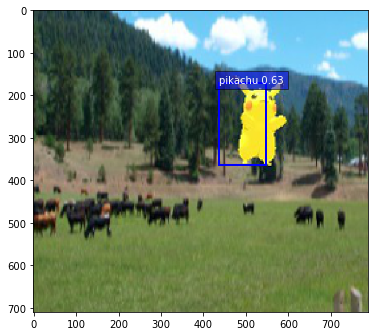

[start test] ...
[gpu(0)]
[num_anchors] 4


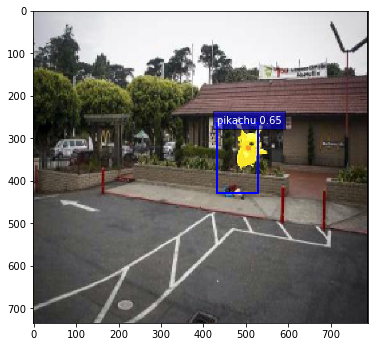

[start test] ...
[gpu(0)]
[num_anchors] 4


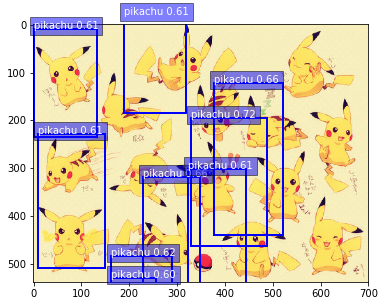

In [18]:
import numpy as np
colors = ['blue', 'green', 'red', 'black', 'magenta']
mpl.rcParams['figure.figsize'] = (6,6)

def display(im, out, threshold=0.5):
    plt.imshow(im.asnumpy())
    for row in out:
        row = row.asnumpy()
        class_id, score = int(row[0]), row[1]
        if class_id < 0 or score < threshold:
            continue
        color = colors[class_id%len(colors)]
        box = row[2:6] * np.array([im.shape[0],im.shape[1]]*2)
        rect = box_to_rect(nd.array(box), color, 2)
        plt.gca().add_patch(rect)

        text = class_names[class_id]
        plt.gca().text(box[0], box[1],
                       '{:s} {:.2f}'.format(text, score),
                       bbox=dict(facecolor=color, alpha=0.5),
                       fontsize=10, color='white')
    plt.show()

def start_test(file_name, data_shape, rgb_mean, num_class, save_model_name, threshold=0.5, load_flag=True):
    ctx = get_gpu(1)
    net = ToySSD(num_class)
    # net.initialize(init.Xavier(magnitude=2), ctx=ctx[0])
    if load_flag is True:               # 加载模型
        net.load_params(filename=save_model_name, ctx=ctx[0])

    x, im = process_image(file_name, data_shape, rgb_mean)
    out = predict(x, net, ctx[0])
    # print('[predict]', out)
    # print('[out_shape]', out.shape)
    display(im, out[0], threshold=threshold)
    
start_test('test_picture/image.png', data_shape, rgb_mean, num_class, save_model_name)
start_test('test_picture/image1.png', data_shape, rgb_mean, num_class, save_model_name)
start_test('test_picture/timg1.jpg', data_shape, rgb_mean, num_class, save_model_name, 0.6)